Episode 0: Reward = 22.89, Epsilon = 0.9950, LR = 0.000500
Episode 10: Reward = 5.67, Epsilon = 0.9464, LR = 0.000500
Episode 20: Reward = 28.89, Epsilon = 0.9001, LR = 0.000500
Episode 30: Reward = 4.69, Epsilon = 0.8561, LR = 0.000500
Episode 40: Reward = 19.43, Epsilon = 0.8142, LR = 0.000500
Episode 50: Reward = 1.41, Epsilon = 0.7744, LR = 0.000500
Episode 60: Reward = 40.72, Epsilon = 0.7366, LR = 0.000500
Episode 70: Reward = 18.48, Epsilon = 0.7005, LR = 0.000500
Episode 80: Reward = 3.89, Epsilon = 0.6663, LR = 0.000500
Episode 90: Reward = 48.62, Epsilon = 0.6337, LR = 0.000500
Episode 100: Reward = 19.56, Epsilon = 0.6027, LR = 0.000500
Episode 110: Reward = 20.55, Epsilon = 0.5733, LR = 0.000500
Episode 120: Reward = 46.91, Epsilon = 0.5452, LR = 0.000500
Episode 130: Reward = 22.36, Epsilon = 0.5186, LR = 0.000500
Episode 140: Reward = 7.09, Epsilon = 0.4932, LR = 0.000500
Episode 150: Reward = 17.36, Epsilon = 0.4691, LR = 0.000500
Episode 160: Reward = 6.47, Epsilon = 0.

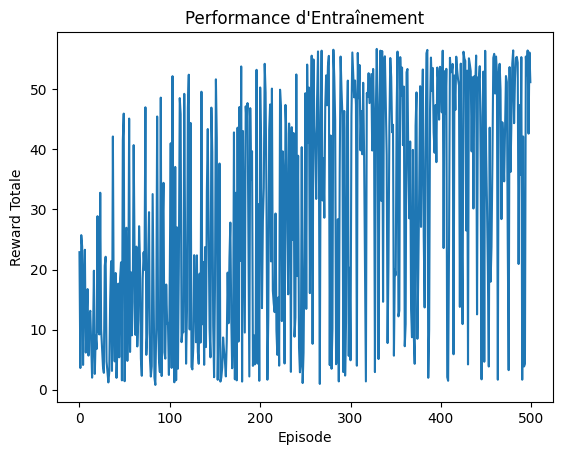

In [1]:
#!/usr/bin/env python3
"""
Implémentation d’un agent Double DQN avec action masking pour l’environnement discrete de Highway.
Ce fichier intègre directement :
  - Le module de configuration
  - Le module MEMORY
  - Le module MODELS
  - Le module AGENTS COMMON (optimizers et factories)
  - Un module d'exploration minimal
  - Le module deep_q_network.abstract (agent abstract)
  - La classe d'agent personnalisée (CustomDQNAgent) et la boucle d'entraînement

Ainsi, vous n’aurez plus besoin d’importer de modules externes depuis rl_agents.
"""

import math
import itertools as it
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
import gymnasium as gym
import highway_env
import logging
from gymnasium import spaces
from collections.abc import Mapping
from gymnasium.core import Env
from collections import namedtuple
from abc import ABC, abstractmethod

logger = logging.getLogger(__name__)

# ============================================================================
# MODULE CONFIGURATION
# ============================================================================

class Configurable(object):
    """
    Conteneur pour une configuration sous forme de dictionnaire.
    La méthode default_config doit être redéfinie dans les classes filles.
    La configuration passée en argument est fusionnée récursivement avec la configuration par défaut.
    """
    def __init__(self, config=None):
        self.config = self.default_config()
        if config:
            Configurable.rec_update(self.config, config)
            Configurable.rec_update(config, self.config)

    def update_config(self, config):
        Configurable.rec_update(self.config, config)

    @classmethod
    def default_config(cls):
        return {}

    @staticmethod
    def rec_update(d, u):
        for k, v in u.items():
            if isinstance(v, Mapping):
                d[k] = Configurable.rec_update(d.get(k, {}), v)
            else:
                d[k] = v
        return d


class Dummy(object):
    pass


_ignored_keys = set(Dummy.__dict__.keys())


class Serializable(dict):
    """
    Sérialise automatiquement les champs d'un objet en dictionnaire.
    """
    def to_dict(self):
        d = {}
        for (key, value) in self.__dict__.items():
            if key not in _ignored_keys:
                if isinstance(value, Serializable):
                    d[key] = value.to_dict()
                else:
                    d[key] = repr(value)
        return d

    def from_dict(self, dictionary):
        for (key, value) in dictionary.items():
            if key in self.__dict__:
                if isinstance(value, Serializable):
                    self.__dict__[key].from_config(dictionary)
                else:
                    self.__dict__[key] = value


def serialize(obj):
    """
    Sérialise un objet en dictionnaire afin de pouvoir le sauvegarder (ex : JSON).
    """
    if hasattr(obj, "config"):
        d = obj.config
    elif isinstance(obj, Serializable):
        d = obj.to_dict()
    else:
        d = {key: repr(value) for (key, value) in obj.__dict__.items()}
    d['__class__'] = repr(obj.__class__)
    if isinstance(obj, Env):
        d['id'] = obj.spec.id
        d['import_module'] = getattr(obj, "import_module", None)
    return d


# ============================================================================
# MODULE MEMORY
# ============================================================================

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'terminal', 'info'))

class ReplayMemory(Configurable):
    """
    Container qui stocke et échantillonne des transitions.
    """
    def __init__(self, config=None, transition_type=Transition):
        super(ReplayMemory, self).__init__(config)
        self.capacity = int(self.config['memory_capacity'])
        self.transition_type = transition_type
        self.memory = []
        self.position = 0

    @classmethod
    def default_config(cls):
        return dict(memory_capacity=10000,
                    n_steps=1,
                    gamma=0.99)

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            self.position = len(self.memory) - 1
        elif len(self.memory) > self.capacity:
            self.memory = self.memory[:self.capacity]
        self.memory[self.position] = self.transition_type(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, collapsed=True):
        if self.config["n_steps"] == 1:
            return random.sample(self.memory, batch_size)
        else:
            indexes = random.sample(range(len(self.memory)), batch_size)
            all_transitions = [self.memory[i:i+self.config["n_steps"]] for i in indexes]
            return map(self.collapse_n_steps, all_transitions) if collapsed else all_transitions

    def collapse_n_steps(self, transitions):
        state, action, cumulated_reward, next_state, done, info = transitions[0]
        discount = 1
        for transition in transitions[1:]:
            if done:
                break
            else:
                _, _, reward, next_state, done, info = transition
                discount *= self.config['gamma']
                cumulated_reward += discount * reward
        return state, action, cumulated_reward, next_state, done, info

    def __len__(self):
        return len(self.memory)

    def is_full(self):
        return len(self.memory) == self.capacity

    def is_empty(self):
        return len(self.memory) == 0


# ============================================================================
# MODULE MODELS
# ============================================================================

def activation_factory(activation_type):
    if activation_type == "RELU":
        return F.relu
    elif activation_type == "TANH":
        return torch.tanh
    else:
        raise ValueError("Unknown activation_type: {}".format(activation_type))

def trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def size_model_config(env, model_config):
    if isinstance(env.observation_space, spaces.Box):
        obs_shape = env.observation_space.shape
    elif isinstance(env.observation_space, spaces.Tuple):
        obs_shape = env.observation_space.spaces[0].shape
    if model_config["type"] == "ConvolutionalNetwork":
        model_config["in_channels"] = int(obs_shape[0])
        model_config["in_height"] = int(obs_shape[1])
        model_config["in_width"] = int(obs_shape[2])
    else:
        model_config["in"] = int(np.prod(obs_shape))

    if isinstance(env.action_space, spaces.Discrete):
        model_config["out"] = int(env.action_space.n)
    elif isinstance(env.action_space, spaces.Tuple):
        model_config["out"] = int(env.action_space.spaces[0].n)

def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    output = torch.matmul(p_attn, value)
    return output, p_attn

class BaseModule(torch.nn.Module):
    """
    Base pour les modules de réseaux de neurones.
    """
    def __init__(self, activation_type="RELU", reset_type="XAVIER", normalize=None):
        super().__init__()
        self.activation = activation_factory(activation_type)
        self.reset_type = reset_type
        self.normalize = normalize
        self.mean = None
        self.std = None

    def _init_weights(self, m):
        if hasattr(m, 'weight'):
            if self.reset_type == "XAVIER":
                torch.nn.init.xavier_uniform_(m.weight.data)
            elif self.reset_type == "ZEROS":
                torch.nn.init.constant_(m.weight.data, 0.)
            else:
                raise ValueError("Unknown reset type")
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.)

    def set_normalization_params(self, mean, std):
        if self.normalize:
            std[std == 0.] = 1.
        self.std = std
        self.mean = mean

    def reset(self):
        self.apply(self._init_weights)

    def forward(self, *input):
        if self.normalize:
            input = (input.float() - self.mean.float()) / self.std.float()
        return NotImplementedError

class MultiLayerPerceptron(BaseModule, Configurable):
    def __init__(self, config):
        super().__init__()
        Configurable.__init__(self, config)
        sizes = [self.config["in"]] + self.config["layers"]
        self.activation = activation_factory(self.config["activation"])
        layers_list = [nn.Linear(sizes[i], sizes[i + 1]) for i in range(len(sizes) - 1)]
        self.layers = nn.ModuleList(layers_list)
        if self.config.get("out", None):
            self.predict = nn.Linear(sizes[-1], self.config["out"])

    @classmethod
    def default_config(cls):
        return {"in": None,
                "layers": [64, 64],
                "activation": "RELU",
                "reshape": "True",
                "out": None}

    def forward(self, x):
        if self.config["reshape"]:
            x = x.reshape(x.shape[0], -1)
        for layer in self.layers:
            x = self.activation(layer(x))
        if self.config.get("out", None):
            x = self.predict(x)
        return x

class DuelingNetwork(BaseModule, Configurable):
    def __init__(self, config):
        super().__init__()
        Configurable.__init__(self, config)
        self.config["base_module"]["in"] = self.config["in"]
        self.base_module = model_factory(self.config["base_module"])
        self.config["value"]["in"] = self.base_module.config["layers"][-1]
        self.config["value"]["out"] = 1
        self.value = model_factory(self.config["value"])
        self.config["advantage"]["in"] = self.base_module.config["layers"][-1]
        self.config["advantage"]["out"] = self.config["out"]
        self.advantage = model_factory(self.config["advantage"])

    @classmethod
    def default_config(cls):
        return {"in": None,
                "base_module": {"type": "MultiLayerPerceptron", "out": None},
                "value": {"type": "MultiLayerPerceptron", "layers": [], "out": None},
                "advantage": {"type": "MultiLayerPerceptron", "layers": [], "out": None},
                "out": None}

    def forward(self, x):
        x = self.base_module(x)
        value = self.value(x).expand(-1, self.config["out"])
        advantage = self.advantage(x)
        return value + advantage - advantage.mean(1).unsqueeze(1).expand(-1, self.config["out"])

class ConvolutionalNetwork(nn.Module, Configurable):
    def __init__(self, config):
        super().__init__()
        Configurable.__init__(self, config)
        self.activation = activation_factory(self.config["activation"])
        self.conv1 = nn.Conv2d(self.config["in_channels"], 16, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2, stride=2)

        def conv2d_size_out(size, kernel_size=2, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(self.config["in_width"])))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(self.config["in_height"])))
        assert convh > 0 and convw > 0
        self.config["head_mlp"]["in"] = convw * convh * 64
        self.config["head_mlp"]["out"] = self.config["out"]
        self.head = model_factory(self.config["head_mlp"])

    @classmethod
    def default_config(cls):
        return {
            "in_channels": None,
            "in_height": None,
            "in_width": None,
            "activation": "RELU",
            "head_mlp": {"type": "MultiLayerPerceptron",
                         "in": None,
                         "layers": [],
                         "activation": "RELU",
                         "reshape": "True",
                         "out": None},
            "out": None
        }

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        return self.head(x)

class EgoAttention(BaseModule, Configurable):
    def __init__(self, config):
        super().__init__()
        Configurable.__init__(self, config)
        self.features_per_head = int(self.config["feature_size"] / self.config["heads"])

        self.value_all = nn.Linear(self.config["feature_size"], self.config["feature_size"], bias=False)
        self.key_all = nn.Linear(self.config["feature_size"], self.config["feature_size"], bias=False)
        self.query_ego = nn.Linear(self.config["feature_size"], self.config["feature_size"], bias=False)
        self.attention_combine = nn.Linear(self.config["feature_size"], self.config["feature_size"], bias=False)

    @classmethod
    def default_config(cls):
        return {"feature_size": 64, "heads": 4, "dropout_factor": 0}

    def forward(self, ego, others, mask=None):
        batch_size = others.shape[0]
        n_entities = others.shape[1] + 1
        input_all = torch.cat((ego.view(batch_size, 1, self.config["feature_size"]), others), dim=1)
        key_all = self.key_all(input_all).view(batch_size, n_entities, self.config["heads"], self.features_per_head)
        value_all = self.value_all(input_all).view(batch_size, n_entities, self.config["heads"], self.features_per_head)
        query_ego = self.query_ego(ego).view(batch_size, 1, self.config["heads"], self.features_per_head)

        key_all = key_all.permute(0, 2, 1, 3)
        value_all = value_all.permute(0, 2, 1, 3)
        query_ego = query_ego.permute(0, 2, 1, 3)
        if mask is not None:
            mask = mask.view((batch_size, 1, 1, n_entities)).repeat((1, self.config["heads"], 1, 1))
        value, attention_matrix = attention(query_ego, key_all, value_all, mask,
                                            nn.Dropout(self.config["dropout_factor"]))
        result = (self.attention_combine(value.reshape((batch_size, self.config["feature_size"]))) + ego.squeeze(1)) / 2
        return result, attention_matrix

class SelfAttention(BaseModule, Configurable):
    def __init__(self, config):
        super().__init__()
        Configurable.__init__(self, config)
        self.features_per_head = int(self.config["feature_size"] / self.config["heads"])

        self.value_all = nn.Linear(self.config["feature_size"], self.config["feature_size"], bias=False)
        self.key_all = nn.Linear(self.config["feature_size"], self.config["feature_size"], bias=False)
        self.query_all = nn.Linear(self.config["feature_size"], self.config["feature_size"], bias=False)
        self.attention_combine = nn.Linear(self.config["feature_size"], self.config["feature_size"], bias=False)

    @classmethod
    def default_config(cls):
        return {"feature_size": 64, "heads": 4, "dropout_factor": 0}

    def forward(self, ego, others, mask=None):
        batch_size = others.shape[0]
        n_entities = others.shape[1] + 1
        input_all = torch.cat((ego.view(batch_size, 1, self.config["feature_size"]), others), dim=1)
        key_all = self.key_all(input_all).view(batch_size, n_entities, self.config["heads"], self.features_per_head)
        value_all = self.value_all(input_all).view(batch_size, n_entities, self.config["heads"], self.features_per_head)
        query_all = self.query_all(input_all).view(batch_size, n_entities, self.config["heads"], self.features_per_head)

        key_all = key_all.permute(0, 2, 1, 3)
        value_all = value_all.permute(0, 2, 1, 3)
        query_all = query_all.permute(0, 2, 1, 3)
        if mask is not None:
            mask = mask.view((batch_size, 1, 1, n_entities)).repeat((1, self.config["heads"], 1, 1))
        value, attention_matrix = attention(query_all, key_all, value_all, mask,
                                            nn.Dropout(self.config["dropout_factor"]))
        result = (self.attention_combine(value.reshape((batch_size, n_entities, self.config["feature_size"]))) + input_all) / 2
        return result, attention_matrix

class EgoAttentionNetwork(BaseModule, Configurable):
    def __init__(self, config):
        super().__init__()
        Configurable.__init__(self, config)
        self.config = config
        if not self.config["embedding_layer"]["in"]:
            self.config["embedding_layer"]["in"] = self.config["in"]
        if not self.config["others_embedding_layer"]["in"]:
            self.config["others_embedding_layer"]["in"] = self.config["in"]
        self.config["output_layer"]["in"] = self.config["attention_layer"]["feature_size"]
        self.config["output_layer"]["out"] = self.config["out"]
        self.ego_embedding = model_factory(self.config["embedding_layer"])
        self.others_embedding = model_factory(self.config["others_embedding_layer"])
        self.self_attention_layer = None
        if self.config["self_attention_layer"]:
            self.self_attention_layer = SelfAttention(self.config["self_attention_layer"])
        self.attention_layer = EgoAttention(self.config["attention_layer"])
        self.output_layer = model_factory(self.config["output_layer"])

    @classmethod
    def default_config(cls):
        return {"in": None,
                "out": None,
                "presence_feature_idx": 0,
                "embedding_layer": {"type": "MultiLayerPerceptron", "layers": [128, 128, 128], "reshape": False},
                "others_embedding_layer": {"type": "MultiLayerPerceptron", "layers": [128, 128, 128], "reshape": False},
                "self_attention_layer": {"type": "SelfAttention", "feature_size": 128, "heads": 4},
                "attention_layer": {"type": "EgoAttention", "feature_size": 128, "heads": 4},
                "output_layer": {"type": "MultiLayerPerceptron", "layers": [128, 128, 128], "reshape": False}}

    def forward(self, x):
        ego_embedded_att, _ = self.forward_attention(x)
        return self.output_layer(ego_embedded_att)

    def split_input(self, x, mask=None):
        ego = x[:, 0:1, :]
        others = x[:, 1:, :]
        if mask is None:
            mask = x[:, :, self.config["presence_feature_idx"]:
                     self.config["presence_feature_idx"] + 1] < 0.5
        return ego, others, mask

    def forward_attention(self, x):
        ego, others, mask = self.split_input(x)
        ego, others = self.ego_embedding(ego), self.others_embedding(others)
        if self.self_attention_layer:
            self_att, _ = self.self_attention_layer(ego, others, mask)
            ego, others, mask = self.split_input(self_att, mask=mask)
        return self.attention_layer(ego, others, mask)

    def get_attention_matrix(self, x):
        _, attention_matrix = self.forward_attention(x)
        return attention_matrix

class AttentionNetwork(BaseModule, Configurable):
    def __init__(self, config):
        super().__init__()
        Configurable.__init__(self, config)
        self.config = config
        if not self.config["embedding_layer"]["in"]:
            self.config["embedding_layer"]["in"] = self.config["in"]
        self.config["output_layer"]["in"] = self.config["attention_layer"]["feature_size"]
        self.config["output_layer"]["out"] = self.config["out"]
        self.embedding = model_factory(self.config["embedding_layer"])
        self.attention_layer = SelfAttention(self.config["attention_layer"])
        self.output_layer = model_factory(self.config["output_layer"])

    @classmethod
    def default_config(cls):
        return {"in": None,
                "out": None,
                "presence_feature_idx": 0,
                "embedding_layer": {"type": "MultiLayerPerceptron", "layers": [128, 128, 128], "reshape": False},
                "attention_layer": {"type": "SelfAttention", "feature_size": 128, "heads": 4},
                "output_layer": {"type": "MultiLayerPerceptron", "layers": [128, 128, 128], "reshape": False}}

    def forward(self, x):
        ego, others, mask = self.split_input(x)
        ego_embedded_att, _ = self.attention_layer(self.embedding(ego),
                                                    self.others_embedding(others), mask)
        return self.output_layer(ego_embedded_att)

    def split_input(self, x):
        ego = x[:, 0:1, :]
        others = x[:, 1:, :]
        mask = x[:, :, self.config["presence_feature_idx"]:
                 self.config["presence_feature_idx"] + 1] < 0.5
        return ego, others, mask

    def get_attention_matrix(self, x):
        ego, others, mask = self.split_input(x)
        _, attention_matrix = self.attention_layer(self.embedding(ego),
                                                    self.others_embedding(others), mask)
        return attention_matrix

def model_factory(config: dict) -> nn.Module:
    if config["type"] == "MultiLayerPerceptron":
        return MultiLayerPerceptron(config)
    elif config["type"] == "DuelingNetwork":
        return DuelingNetwork(config)
    elif config["type"] == "ConvolutionalNetwork":
        return ConvolutionalNetwork(config)
    elif config["type"] == "EgoAttentionNetwork":
        return EgoAttentionNetwork(config)
    else:
        raise ValueError("Unknown model type")


# ============================================================================
# MODULE AGENTS COMMON (Optimizers et Factories)
# ============================================================================

class Ranger(Optimizer):
    """
    Ranger optimizer (combinaison de RAdam et Lookahead).
    Credits :
     - Lookahead: https://github.com/lonePatient/lookahead_pytorch
     - RAdam: https://github.com/LiyuanLucasLiu/RAdam
     - Ralamb: https://gist.github.com/redknightlois/c4023d393eb8f92bb44b2ab582d7ec20
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, k=5, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError('Invalid slow update rate: ', alpha)
        if not 1 <= k:
            raise ValueError('Invalid lookahead steps: ', k)
        if not lr > 0:
            raise ValueError('Invalid Learning Rate: ', lr)
        if not eps > 0:
            raise ValueError('Invalid eps: ', eps)
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)
        for group in self.param_groups:
            group["step_counter"] = 0
        self.alpha = alpha
        self.k = k
        self.radam_buffer = [[None, None, None] for _ in range(10)]
        # Lookahead weights ne sont pas initialisées ici

    def __setstate__(self, state):
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')
                p_data_fp32 = p.data.float()
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                state['step'] += 1
                buffered = self.radam_buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                                                            (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                radam_norm = p_data_fp32.pow(2).sum().sqrt()
                trust_ratio = 1 if (weight_norm == 0 or radam_norm == 0) else weight_norm / radam_norm
                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio
                if N_sma > 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * trust_ratio, exp_avg)
                p.data.copy_(p_data_fp32)
        return loss

def loss_function_factory(loss_function):
    if loss_function == "l2":
        return F.mse_loss
    elif loss_function == "l1":
        return F.l1_loss
    elif loss_function == "smooth_l1":
        return F.smooth_l1_loss
    elif loss_function == "bce":
        return F.binary_cross_entropy
    else:
        raise ValueError("Unknown loss function : {}".format(loss_function))

def optimizer_factory(optimizer_type, params, lr=None, weight_decay=None, k=None, **kwargs):
    if optimizer_type == "ADAM":
        return torch.optim.Adam(params=params, lr=lr, weight_decay=weight_decay)
    elif optimizer_type == "RMS_PROP":
        return torch.optim.RMSprop(params=params, weight_decay=weight_decay)
    elif optimizer_type == "RANGER":
        return Ranger(params=params, lr=lr, weight_decay=weight_decay, k=k)
    else:
        raise ValueError("Unknown optimizer type: {}".format(optimizer_type))


# ============================================================================
# MODULE EXPLORATION
# ============================================================================

class EpsilonGreedyExploration:
    def __init__(self, config, action_space):
        self.method = config.get("method", "EpsilonGreedy")
        self.epsilon = 0.1
        self.action_space = action_space
        self.time = 0
        self.writer = None

    def step_time(self):
        self.time += 1

    def update(self, values):
        pass

    def sample(self):
        return random.choice(list(range(self.action_space.n)))

    def get_distribution(self):
        n = self.action_space.n
        return [1.0/n] * n

    def set_time(self, time):
        self.time = time

    def seed(self, seed=None):
        random.seed(seed)
        return seed

    def set_writer(self, writer):
        self.writer = writer

def exploration_factory(config, action_space):
    return EpsilonGreedyExploration(config, action_space)


# ============================================================================
# MODULE AGENT ABSTRACT (deep_q_network.abstract)
# ============================================================================

class AbstractStochasticAgent(Configurable, ABC):
    def __init__(self, config=None):
        super().__init__(config)
        self.writer = None

    def set_writer(self, writer):
        self.writer = writer

class AbstractDQNAgent(AbstractStochasticAgent, ABC):
    def __init__(self, env, config=None):
        super(AbstractDQNAgent, self).__init__(config)
        self.env = env
        assert isinstance(env.action_space, spaces.Discrete) or isinstance(env.action_space, spaces.Tuple), \
            "Only compatible with Discrete action spaces."
        self.memory = ReplayMemory(self.config)
        self.exploration_policy = exploration_factory(self.config["exploration"], self.env.action_space)
        self.training = True
        self.previous_state = None
        self.steps = 0

    @classmethod
    def default_config(cls):
        return dict(model=dict(type="DuelingNetwork"),
                    optimizer=dict(type="ADAM",
                                   lr=5e-4,
                                   weight_decay=0,
                                   k=5),
                    loss_function="l2",
                    memory_capacity=50000,
                    batch_size=100,
                    gamma=0.99,
                    device="cuda:best",
                    exploration=dict(method="EpsilonGreedy"),
                    target_update=1,
                    double=True)

    def record(self, state, action, reward, next_state, done, info):
        if not self.training:
            return
        if isinstance(state, tuple) and isinstance(action, tuple):
            [self.memory.push(agent_state, agent_action, reward, agent_next_state, done, info)
             for agent_state, agent_action, agent_next_state in zip(state, action, next_state)]
        else:
            self.memory.push(state, action, reward, next_state, done, info)
        batch = self.sample_minibatch()
        if batch:
            loss, _, _ = self.compute_bellman_residual(batch)
            self.step_optimizer(loss)
            self.update_target_network()

    def act(self, state, step_exploration_time=True):
        self.previous_state = state
        if step_exploration_time:
            self.exploration_policy.step_time()
        if isinstance(state, tuple):
            return tuple(self.act(agent_state, step_exploration_time=False) for agent_state in state)
        values = self.get_state_action_values(state)
        self.exploration_policy.update(values)
        return self.exploration_policy.sample()

    def sample_minibatch(self):
        if len(self.memory) < self.config["batch_size"]:
            return None
        transitions = self.memory.sample(self.config["batch_size"])
        return Transition(*zip(*transitions))

    def update_target_network(self):
        self.steps += 1
        if self.steps % self.config["target_update"] == 0:
            self.target_net.load_state_dict(self.value_net.state_dict())

    @abstractmethod
    def compute_bellman_residual(self, batch, target_state_action_value=None):
        raise NotImplementedError

    @abstractmethod
    def get_batch_state_values(self, states):
        raise NotImplementedError

    @abstractmethod
    def get_batch_state_action_values(self, states):
        raise NotImplementedError

    def get_state_value(self, state):
        values, actions = self.get_batch_state_values([state])
        return values[0], actions[0]

    def get_state_action_values(self, state):
        return self.get_batch_state_action_values([state])[0]

    def step_optimizer(self, loss):
        raise NotImplementedError

    def seed(self, seed=None):
        return self.exploration_policy.seed(seed)

    def reset(self):
        pass

    def set_writer(self, writer):
        super().set_writer(writer)
        try:
            self.exploration_policy.set_writer(writer)
        except AttributeError:
            pass

    def action_distribution(self, state):
        self.previous_state = state
        values = self.get_state_action_values(state)
        self.exploration_policy.update(values)
        return self.exploration_policy.get_distribution()

    def set_time(self, time):
        self.exploration_policy.set_time(time)

    def eval(self):
        self.training = False
        self.config['exploration']['method'] = "Greedy"
        self.exploration_policy = exploration_factory(self.config["exploration"], self.env.action_space)


# ============================================================================
# CLASSE D'AGENT PERSONNALISÉ : CustomDQNAgent
# ============================================================================

class CustomDQNAgent(AbstractDQNAgent):
    def __init__(self, env, config):
        super(CustomDQNAgent, self).__init__(env, config)
        self.config = config
        size_model_config(self.env, self.config["model"])
        self.value_net = model_factory(self.config["model"])
        self.target_net = model_factory(self.config["model"])
        self.target_net.load_state_dict(self.value_net.state_dict())
        self.target_net.eval()
        logger.debug("Nombre de paramètres entraînables : {}".format(trainable_parameters(self.value_net)))
        self.device = torch.device(self.config["device"] if torch.cuda.is_available() else "cpu")
        self.value_net.to(self.device)
        self.target_net.to(self.device)
        self.loss_function = loss_function_factory(self.config["loss_function"])
        self.optimizer = optimizer_factory(self.config["optimizer"]["type"],
                                           self.value_net.parameters(),
                                           lr=self.config["optimizer"]["lr"],
                                           weight_decay=self.config["optimizer"]["weight_decay"],
                                           k=self.config["optimizer"].get("k", None))
        memory_config = self.config.get("memory", ReplayMemory.default_config())
        self.replay_buffer = ReplayMemory(memory_config)
        self.batch_size = self.config.get("batch_size", 64)
        self.gamma = self.config.get("gamma", 0.99)
        self.epsilon = self.config.get("epsilon_start", 1.0)
        self.epsilon_min = self.config.get("epsilon_min", 0.05)
        self.epsilon_decay = self.config.get("epsilon_decay", 0.995)
        self.action_dim = self.env.action_space.n
        self.steps = 0

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            available_actions = list(range(self.action_dim))
            if is_risky(state, self.config) and 1 in available_actions:
                available_actions.remove(1)
                if len(available_actions) == 0:
                    available_actions = [1]
            return random.choice(available_actions)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.value_net(state_tensor).squeeze(0).cpu().numpy()
        if is_risky(state, self.config):
            q_values[1] = -float('inf')
        return int(np.argmax(q_values))

    def update_epsilon(self, current_episode, total_episodes):
        if current_episode > total_episodes // 2:
            self.epsilon = self.epsilon_min
        else:
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def step_optimizer(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.value_net.parameters():
            if param.grad is not None:
                param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def compute_bellman_residual(self, batch, target_state_action_value=None):
        if not isinstance(batch.state, torch.Tensor):
            state = torch.stack([torch.tensor(s, dtype=torch.float) for s in batch.state]).to(self.device)
            action = torch.tensor(batch.action, dtype=torch.long).to(self.device)
            reward = torch.tensor(batch.reward, dtype=torch.float).to(self.device)
            next_state = torch.stack([torch.tensor(s, dtype=torch.float) for s in batch.next_state]).to(self.device)
            terminal = torch.tensor(batch.terminal, dtype=torch.bool).to(self.device)
            batch = Transition(state, action, reward, next_state, terminal, batch.info)
        state_action_values = self.value_net(batch.state)
        state_action_values = state_action_values.gather(1, batch.action.unsqueeze(1)).squeeze(1)
        if target_state_action_value is None:
            with torch.no_grad():
                if self.config.get("double", True):
                    _, best_actions = self.value_net(batch.next_state).max(1)
                    best_values = self.target_net(batch.next_state).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                else:
                    best_values, _ = self.target_net(batch.next_state).max(1)
                next_state_values = best_values
                target_state_action_value = batch.reward + self.gamma * (~batch.terminal) * next_state_values
        loss = self.loss_function(state_action_values, target_state_action_value)
        return loss, target_state_action_value, batch

    def get_batch_state_values(self, states):
        state_tensor = torch.FloatTensor(np.array(states)).to(self.device)
        with torch.no_grad():
            q_values = self.value_net(state_tensor).cpu().numpy()
        values = q_values.max(axis=1)
        actions = q_values.argmax(axis=1)
        return values, actions

    def get_batch_state_action_values(self, states):
        state_tensor = torch.FloatTensor(np.array(states)).to(self.device)
        with torch.no_grad():
            q_values = self.value_net(state_tensor).cpu().numpy()
        return q_values


# ============================================================================
# FONCTIONS D'AIDE POUR LE REWARD SHAPING ET L'ACTION MASKING
# ============================================================================

def is_risky(state, config):
    grid_range = config["observation"]["grid_size"][0]
    grid_step = config["observation"]["grid_step"][0]
    nx = int((grid_range[1] - grid_range[0]) / grid_step)
    ny = int((config["observation"]["grid_size"][1][1] - config["observation"]["grid_size"][1][0]) /
             config["observation"]["grid_step"][1])
    num_features = 7  # ['presence', 'x', 'y', 'vx', 'vy', 'cos_h', 'sin_h']
    if state.size != nx * ny * num_features:
        return False
    grid = state.reshape(nx, ny, num_features)
    front_presence = grid[-1, :, 0]
    return np.any(front_presence > 0.5)

def shape_reward(reward, action, state, config):
    shaped = reward
    if reward <= config.get("collision_reward", -1):
        shaped = reward * 2
    if action == 1 and is_risky(state, config):
        shaped -= 0.5
    return shaped


# ============================================================================
# BOUCLE D'ENTRAÎNEMENT ET FONCTIONS D'AFFICHAGE
# ============================================================================

def train(agent, env, num_episodes=500, sync_target_every=10):
    all_rewards = []
    for ep in range(num_episodes):
        state, _ = env.reset()
        state = state.flatten()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = next_state.flatten()
            done = terminated or truncated
            shaped_reward = shape_reward(reward, action, state, agent.config)
            agent.replay_buffer.push(state, action, shaped_reward, next_state, done, {})
            if len(agent.replay_buffer) >= agent.batch_size:
                batch_samples = list(agent.replay_buffer.sample(agent.batch_size))
                batch_states = [trans.state for trans in batch_samples]
                batch_actions = [trans.action for trans in batch_samples]
                batch_rewards = [trans.reward for trans in batch_samples]
                batch_next_states = [trans.next_state for trans in batch_samples]
                batch_terminals = [trans.terminal for trans in batch_samples]
                batched_transition = Transition(
                    state=batch_states,
                    action=batch_actions,
                    reward=batch_rewards,
                    next_state=batch_next_states,
                    terminal=batch_terminals,
                    info={}
                )
                loss, _, _ = agent.compute_bellman_residual(batched_transition)
                agent.step_optimizer(loss)
            state = next_state
            total_reward += reward
        agent.update_epsilon(ep, num_episodes)
        if ep % sync_target_every == 0:
            agent.target_net.load_state_dict(agent.value_net.state_dict())
        if ep % 10 == 0:
            current_lr = agent.optimizer.param_groups[0]['lr']
            print(f"Episode {ep}: Reward = {total_reward:.2f}, Epsilon = {agent.epsilon:.4f}, LR = {current_lr:.6f}")
        all_rewards.append(total_reward)
    return all_rewards

def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward Totale")
    plt.title("Performance d'Entraînement")
    plt.show()


# ============================================================================
# PARTIE PRINCIPALE
# ============================================================================

if __name__ == "__main__":
    with open("config/1-highway-discrete-config.pkl", "rb") as f:
        config = pickle.load(f)
    env = gym.make("highway-fast-v0", render_mode="human")
    env.unwrapped.configure(config)
    observation, _ = env.reset()
    agent = CustomDQNAgent(env, config)
    rewards = train(agent, env)
    plot_rewards(rewards)
